In [386]:
import pickle
from pathlib2 import Path
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'retina'

In [387]:
# Read the training and test data sets, change paths if needed
PATH_TO_DATA = Path('C:/Users/varvara tihonova/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/')

times = ['time%s' % i for i in range(1, 11)]
train_df = pd.read_csv(PATH_TO_DATA / 'train_sessions.csv',
                       index_col='session_id', parse_dates=times)
test_df = pd.read_csv(PATH_TO_DATA / 'test_sessions.csv',
                      index_col='session_id', parse_dates=times)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [388]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)

# Load websites dictionary
with open(PATH_TO_DATA / 'site_dic.pkl', "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), 
                          columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


In [389]:
top_sites = pd.Series(train_df[train_df.target==1][sites].values.flatten()
                     ).value_counts().sort_values(ascending=False).head(10)
print(top_sites)
sites_dict.loc[top_sites.index]

77     1382
80     1354
76     1307
29      897
21      857
81      609
879     522
22      522
75      451
82      447
dtype: int64


,site
77,i1.ytimg.com
80,s.youtube.com
76,www.youtube.com
29,www.facebook.com
21,www.google.fr
81,r4---sn-gxo5uxg-jqbe.googlevideo.com
879,r1---sn-gxo5uxg-jqbe.googlevideo.com
22,apis.google.com
75,s.ytimg.com
82,r2---sn-gxo5uxg-jqbe.googlevideo.com


In [390]:
# Create a separate dataframe where we will work with timestamps
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']

# Find sessions' starting and ending
time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)

# Calculate sessions' duration in seconds
time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

time_df.head()

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0


In [79]:
def avg(a,b):
    return abs(a-b)/max(a,b)<=0.05


In [80]:
t_other=time_df[time_df.target==0].seconds.max()

In [81]:
t_Alise=time_df[time_df.target==1].seconds.max()

In [53]:
avg(t_Alise,t_other)

True

In [82]:
std_o=time_df[time_df.target==0].seconds.std()

In [85]:
std_a=time_df[time_df.target==1].seconds.std()

In [86]:
avg(std_a,std_o)

False

In [87]:
more=time_df[(time_df.target==1)&(time_df.seconds>=40)]

In [88]:
more.seconds.count()*100/time_df[time_df.target==1].seconds.count()

24.11841532433609

In [391]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

In [392]:
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [393]:
# sequence of indices
sites_flatten = full_sites.values.flatten()

# and the matrix we are looking for 
# (make sure you understand which of the `csr_matrix` constructors is used here)
# a further toy example will help you with it
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

In [394]:
full_sites_sparse.shape

(336358, 48371)

In [395]:
print('{0} elements * {1} bytes = {2} bytes'.format(full_sites_sparse.count_nonzero(), 8, 
                                                    full_sites_sparse.count_nonzero() * 8))
# Or just like this:
print('sparse_matrix_size = {0} bytes'.format(full_sites_sparse.data.nbytes))

1866898 elements * 8 bytes = 14935184 bytes
sparse_matrix_size = 7467592 bytes


In [396]:
# data, create the list of ones, length of which equal to the number of elements in the initial dataframe (9)
# By summing the number of ones in the cell, we get the frequency,
# number of visits to a particular site per session
data = [1] * 9

# To do this, you need to correctly distribute the ones in cells
# Indices - website ids, i.e. columns of a new matrix. We will sum ones up grouping them by sessions (ids)
indices = [1, 0, 0, 1, 3, 1, 2, 3, 4]

# Indices for the division into rows (sessions)
# For example, line 0 is the elements between the indices [0; 3) - the rightmost value is not included
# Line 1 is the elements between the indices [3; 6)
# Line 2 is the elements between the indices [6; 9) 
indptr = [0, 3, 6, 9]

# Aggregate these three variables into a tuple and compose a matrix
# To display this matrix on the screen transform it into the usual "dense" matrix
mat=csr_matrix((data, indices, indptr)).todense()

In [163]:
mat=mat[:,1:5]
mat

matrix([[1, 0, 0, 0],
        [2, 0, 1, 0],
        [0, 1, 1, 1]])

In [166]:
mat.nonzero()[0].size/mat.size*100

50.0

In [417]:
def get_auc_lr_valid(X, y, C, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [397]:
%%time
# Select the training set from the united dataframe (where we have the answers)
X_train = full_sites_sparse[:idx_split, :]

# Calculate metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9203542327869803
Wall time: 7.77 s


In [398]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [399]:
# Train the model on the whole training data set
# Use random_state=17 for repeatability
# Parameter C=1 by default, but here we set it explicitly
lr = LogisticRegression(C=0.5, random_state=17, solver='liblinear').fit(X_train, y_train)

# Make a prediction for test data set
X_test = full_sites_sparse[idx_split:,:]
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'baseline_1.csv')

In [400]:
# Dataframe for new features
full_new_feat = pd.DataFrame(index=full_df.index)

# Add start_month feature
full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 
                                                      100 * ts.year + ts.month).astype('float64')

In [338]:
# Dataframe for new features
full_new_feat = pd.DataFrame(index=train_df[train_df.target==1].index)

# Add start_month feature
full_new_feat['start_month'] = train_df[train_df.target==1]['time1'].apply(lambda ts: 
                                                      100 * ts.year + ts.month).astype('float64')

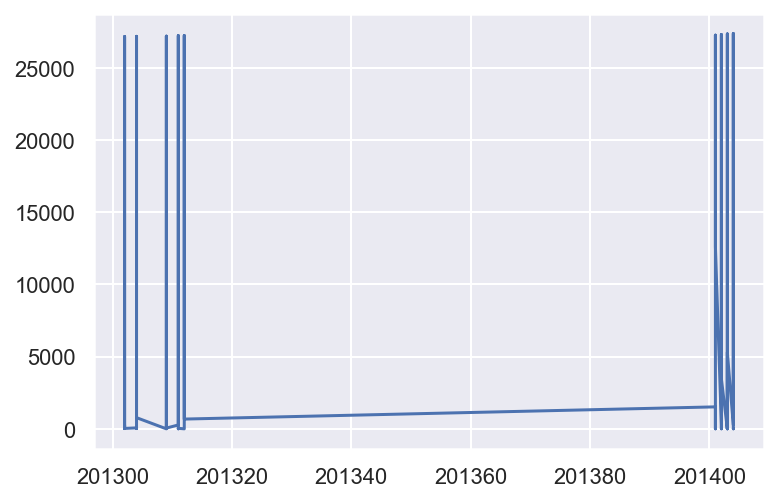

In [339]:
plt.plot(full_new_feat,train_df[train_df.target==1]['site1'])

In [401]:
# Add the new feature to the sparse matrix
tmp = full_new_feat[['start_month']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.7508354860175162


In [402]:
# Add the new standardized feature to the sparse matrix
tmp = StandardScaler().fit_transform(full_new_feat)
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9201768552333474


In [403]:
%%time
full_new_feat['n_unique_sites'] = full_df[sites].replace(0, np.NaN).nunique(axis=1, dropna=True).astype('float64')

Wall time: 1min 41s


In [404]:
full_new_feat.head()

,start_month,n_unique_sites
session_id,,
21669,201301.0,2.0
54843,201301.0,2.0
77292,201301.0,6.0
114021,201301.0,5.0
146670,201301.0,6.0


In [407]:
tmp = StandardScaler().fit_transform(full_new_feat)
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9550387905839843


In [406]:
full_new_feat['start_hour']=full_df['time1'].apply(lambda ts: ts.hour).values

In [408]:
full_new_feat['morning']= ((full_new_feat.start_hour >= 7) & (full_new_feat.start_hour <= 11)).astype('int')

In [409]:
tmp = StandardScaler().fit_transform(full_new_feat)
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

# Compute metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.95660771391582


In [410]:
# Compose the training set
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 
                                                           'start_hour', 
                                                           'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))

# Capture the quality with default parameters
score_C_1 = get_auc_lr_valid(X_train, y_train)
print(score_C_1)

0.9602380663401108


In [411]:
Cs = np.logspace(-3, 1, 10)

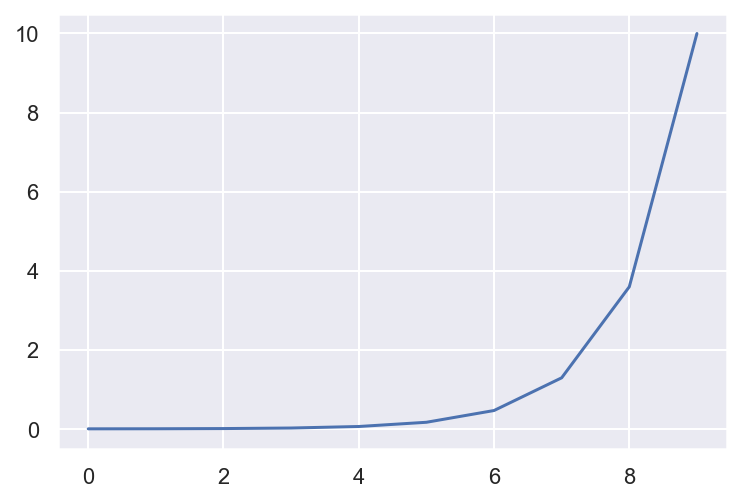

In [412]:
plt.plot(Cs)

In [421]:
# Compose the training set
for i,el in enumerate([0.17,0.46,1.29,3.14]):
    tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 
                                                               'start_hour', 
                                                               'morning']])
    X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                                 tmp_scaled[:idx_split,:]]))

    # Capture the quality with default parameters
    score_C_1 = get_auc_lr_valid(X_train, y_train,el)
    print(score_C_1)
    

0.9612140202841422
0.9603351333758435
0.9586715583621969
0.9562688850484762


In [423]:
# Prepare the training and test data
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 
                                                           'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:], 
                            tmp_scaled[idx_split:,:]]))

# Train the model on the whole training data set using optimal regularization parameter
lr = LogisticRegression(C=0.17, random_state=17, solver='liblinear').fit(X_train, y_train)

# Make a prediction for the test set
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'baseline_2.csv')